# Spotify Analysis

In this notebook, I will be analyzing Spotify songs and using their audio features to predict song popularity, classify song genres, and create song recommendations based on my likes and dislikes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from secrets import *
import warnings
warnings.filterwarnings("ignore")

### Get Tracks and Audio Features using Spotify API

In [2]:
client_id = clientId
client_secret = clientSecret

spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id, client_secret))

def get_playlist_tracks(username, playlist_id):
    response = spotify.user_playlist_tracks(username, playlist_id)
    results = response["items"]

    while len(results) < response["total"]:
        response = spotify.user_playlist_tracks(username, playlist_id, limit=100, offset=len(results))
        results.extend(response["items"])
    return results

results = get_playlist_tracks('1249181242','5US5rmLGDEXwOOf0DN2sFJ')
results2 = get_playlist_tracks('1249181242','77wTmEkqX21ayTWS1swCDA')


In [3]:
data = pd.json_normalize(i['track'] for i in results)
data['artists'] = [data['artists'][i][0]['name'] for i in range(len(data['artists']))]
data2 = pd.json_normalize(i['track'] for i in results2)
data2['artists'] = [data2['artists'][i][0]['name'] for i in range(len(data2['artists']))]

def get_features(df):
    features=[]
    for i in df['id']:
        try:
            features.append(spotify.audio_features(i))
        except:
            continue;
    features = pd.json_normalize(i[0] for i in features)
    return features

features = get_features(data)
features2 = get_features(data2)

likes = data[['id','name','album.name','artists','popularity']].merge(features).drop(['uri','track_href','analysis_url','type'],axis=1)
likes['like'] = 1
dislikes = data2[['id','name','album.name','artists','popularity']].merge(features2).drop(['uri','track_href','analysis_url','type'],axis=1)
dislikes['like'] = 0

df = likes.append(dislikes).reset_index(drop=True)

In [4]:
genres = pd.read_csv('data_w_genres.csv')
with_genres = genres[['genres','artists']].merge(df)
with_genres['genres'] = with_genres['genres'].str.split(',')
for i in range(len(with_genres['genres'])):
    if any('edm' in j for j in with_genres['genres'][i]):
        with_genres['genres'][i] = 'edm'
    elif with_genres['artists'][i] == 'Cash Cash':
        with_genres['genres'][i] = 'edm'
    elif with_genres['artists'][i] == 'Cashmere Cat':
        with_genres['genres'][i] = 'edm'
    elif any('chillwave' in j for j in with_genres['genres'][i]):
        with_genres['genres'][i] = 'edm'
    elif any('electro house' in j for j in with_genres['genres'][i]):
        with_genres['genres'][i] = 'edm'
    elif any('arkansas country' in j for j in with_genres['genres'][i]):
        with_genres['genres'][i] = 'edm'
    elif any('c-pop' in j for j in with_genres['genres'][i]):
        with_genres['genres'][i] = 'c-pop'
    elif any('mandopop' in j for j in with_genres['genres'][i]):
        with_genres['genres'][i] = 'c-pop'
    elif any('classical performance' in j for j in with_genres['genres'][i]):
        with_genres['genres'][i] = 'c-pop'
    elif any('anthem worship' in j for j in with_genres['genres'][i]):
        with_genres['genres'][i] = 'c-pop'
    elif any('country' in j for j in with_genres['genres'][i]):
        with_genres['genres'][i] = 'country'
    elif any('bluegrass' in j for j in with_genres['genres'][i]):
        with_genres['genres'][i] = 'country'
    elif any('r&b' in j for j in with_genres['genres'][i]):
        with_genres['genres'][i] = 'r&b'
    elif any('rap' in j for j in with_genres['genres'][i]):
        with_genres['genres'][i] = 'hip hop'
    elif any('emo rap' in j for j in with_genres['genres'][i]):
        with_genres['genres'][i] = 'hip hop'
    elif any('afroswing' in j for j in with_genres['genres'][i]):
        with_genres['genres'][i] = 'hip hop'
    elif any('brooklyn drill' in j for j in with_genres['genres'][i]):
        with_genres['genres'][i] = 'hip hop'
    elif any('hip hop' in j for j in with_genres['genres'][i]):
        with_genres['genres'][i] = 'hip hop'
    elif any('indie rockism' in j for j in with_genres['genres'][i]):
        with_genres['genres'][i] = 'rock'
    elif any('beatlesque' in j for j in with_genres['genres'][i]):
        with_genres['genres'][i] = 'rock'
    elif any('glam' in j for j in with_genres['genres'][i]):
        with_genres['genres'][i] = 'rock'
    elif any('rock' in j for j in with_genres['genres'][i]):
        with_genres['genres'][i] = 'rock'
    elif any('classical' in j for j in with_genres['genres'][i]):
        with_genres['genres'][i] = 'instrumental'
    elif any('instrumental' in j for j in with_genres['genres'][i]):
        with_genres['genres'][i] = 'instrumental'
    elif any('soundtrack' in j for j in with_genres['genres'][i]):
        with_genres['genres'][i] = 'instrumental'
    elif any('classify' in j for j in with_genres['genres'][i]):
        with_genres['genres'][i] = 'instrumental'
    elif any('epicore' in j for j in with_genres['genres'][i]):
        with_genres['genres'][i] = 'instrumental'
    elif any('contemporary country' in j for j in with_genres['genres'][i]):
        with_genres['genres'][i] = 'contemporary country'
    elif any('indie cafe pop' in j for j in with_genres['genres'][i]):
        with_genres['genres'][i] = 'pop'
    elif any('ccm' in j for j in with_genres['genres'][i]):
        with_genres['genres'][i] = 'pop'
    elif any('pop' in j for j in with_genres['genres'][i]):
        with_genres['genres'][i] = 'pop'
    else:
        with_genres['genres'][i] = with_genres['genres'][i][0].replace("[","").replace("'","").replace("]","")
with_genres.head()

,genres,artists,id,name,album.name,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,like
0,hip hop,21 Savage,5SWnsxjhdcEDc7LJjq9UHk,Runnin,SAVAGE MODE II,86,0.819,0.626,10,-4.574,0,0.2020,0.00748,0.101000,0.167,0.415,143.010,195906,4,0
1,hip hop,21 Savage,4Q34FP1AT7GEl9oLgNtiWj,Mr. Right Now (feat. Drake),SAVAGE MODE II,85,0.647,0.667,5,-5.563,1,0.3040,0.23100,0.000000,0.133,0.704,172.080,193839,4,0
2,hip hop,21 Savage,4IO8X9W69dIQe0EC5ALXhq,Immortal,Immortal,72,0.741,0.870,6,-3.494,0,0.5030,0.00813,0.000000,0.114,0.663,184.194,254723,4,0
3,hip hop,24kGoldn,0c7K73roy6RW4ebDkf4yGh,VALENTINO,VALENTINO,67,0.745,0.718,9,-4.853,0,0.1830,0.19700,0.000000,0.134,0.539,151.097,179133,4,0
4,edm,3LAU,3D37T7euWvVJ45evRmriIh,Better With You,Better With You,62,0.571,0.752,3,-4.872,1,0.0293,0.01960,0.000069,0.114,0.250,102.043,192941,4,1


In [5]:
with_genres.groupby('genres').count()

,artists,id,name,album.name,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,like
genres,,,,,,,,,,,,,,,,,,,
,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
c-pop,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36
country,184,184,184,184,184,184,184,184,184,184,184,184,184,184,184,184,184,184,184
edm,134,134,134,134,134,134,134,134,134,134,134,134,134,134,134,134,134,134,134
hip hop,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180
instrumental,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28
pop,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168
r&b,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
rock,130,130,130,130,130,130,130,130,130,130,130,130,130,130,130,130,130,130,130


In [6]:
df = with_genres[with_genres['genres']!=''].reset_index(drop=True)
df.head()

,genres,artists,id,name,album.name,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,like
0,hip hop,21 Savage,5SWnsxjhdcEDc7LJjq9UHk,Runnin,SAVAGE MODE II,86,0.819,0.626,10,-4.574,0,0.2020,0.00748,0.101000,0.167,0.415,143.010,195906,4,0
1,hip hop,21 Savage,4Q34FP1AT7GEl9oLgNtiWj,Mr. Right Now (feat. Drake),SAVAGE MODE II,85,0.647,0.667,5,-5.563,1,0.3040,0.23100,0.000000,0.133,0.704,172.080,193839,4,0
2,hip hop,21 Savage,4IO8X9W69dIQe0EC5ALXhq,Immortal,Immortal,72,0.741,0.870,6,-3.494,0,0.5030,0.00813,0.000000,0.114,0.663,184.194,254723,4,0
3,hip hop,24kGoldn,0c7K73roy6RW4ebDkf4yGh,VALENTINO,VALENTINO,67,0.745,0.718,9,-4.853,0,0.1830,0.19700,0.000000,0.134,0.539,151.097,179133,4,0
4,edm,3LAU,3D37T7euWvVJ45evRmriIh,Better With You,Better With You,62,0.571,0.752,3,-4.872,1,0.0293,0.01960,0.000069,0.114,0.250,102.043,192941,4,1


## EDA

In [7]:
df.describe()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,like
count,874.000000,874.000000,874.000000,874.000000,874.000000,874.00000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000
mean,59.858124,0.605624,0.605767,5.108696,-7.358462,0.73913,0.085747,0.294516,0.036772,0.167992,0.470916,123.416921,217922.874142,3.941648,0.462243
std,24.263360,0.152901,0.202842,3.591812,3.549207,0.43936,0.091112,0.290726,0.159250,0.122360,0.235159,29.039479,63606.663532,0.355007,0.498858
min,0.000000,0.120000,0.018800,0.000000,-29.484000,0.00000,0.024700,0.000084,0.000000,0.024400,0.034700,62.948000,106000.000000,1.000000,0.000000
25%,56.000000,0.501000,0.468250,2.000000,-8.679500,0.00000,0.035000,0.056550,0.000000,0.094700,0.275250,99.985500,181375.000000,4.000000,0.000000
50%,67.000000,0.613500,0.630500,5.000000,-6.607500,1.00000,0.046850,0.186500,0.000000,0.120000,0.450000,123.223000,205697.000000,4.000000,0.000000
75%,75.000000,0.709000,0.757000,9.000000,-5.070500,1.00000,0.084900,0.458000,0.000056,0.203750,0.657250,143.929750,239460.250000,4.000000,1.000000
max,95.000000,0.974000,0.989000,11.000000,-0.484000,1.00000,0.541000,0.994000,0.978000,0.949000,0.966000,202.006000,774507.000000,5.000000,1.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 874 entries, 0 to 873
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   genres            874 non-null    object 
 1   artists           874 non-null    object 
 2   id                874 non-null    object 
 3   name              874 non-null    object 
 4   album.name        874 non-null    object 
 5   popularity        874 non-null    int64  
 6   danceability      874 non-null    float64
 7   energy            874 non-null    float64
 8   key               874 non-null    int64  
 9   loudness          874 non-null    float64
 10  mode              874 non-null    int64  
 11  speechiness       874 non-null    float64
 12  acousticness      874 non-null    float64
 13  instrumentalness  874 non-null    float64
 14  liveness          874 non-null    float64
 15  valence           874 non-null    float64
 16  tempo             874 non-null    float64
 1

In [9]:
df.shape

(874, 20)

In [10]:
df.drop('like',axis=1).corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
popularity,1.00,0.20,0.08,0.03,0.21,-0.09,0.18,-0.13,-0.20,0.02,0.03,0.05,-0.14,0.05
danceability,0.20,1.00,0.08,0.02,0.23,-0.09,0.35,-0.24,-0.31,-0.01,0.31,-0.09,-0.39,0.16
energy,0.08,0.08,1.00,0.00,0.68,0.03,0.08,-0.71,-0.31,0.18,0.48,0.15,-0.02,0.21
key,0.03,0.02,0.00,1.00,-0.03,-0.08,-0.02,0.02,-0.02,0.04,0.04,-0.01,-0.02,0.02
loudness,0.21,0.23,0.68,-0.03,1.00,0.04,0.09,-0.53,-0.58,0.12,0.22,0.10,-0.23,0.21
mode,-0.09,-0.09,0.03,-0.08,0.04,1.00,-0.20,0.06,-0.04,-0.00,0.12,-0.03,-0.01,0.03
speechiness,0.18,0.35,0.08,-0.02,0.09,-0.20,1.00,-0.22,-0.08,0.03,0.05,0.16,-0.16,0.05
acousticness,-0.13,-0.24,-0.71,0.02,-0.53,0.06,-0.22,1.00,0.32,-0.16,-0.30,-0.14,0.09,-0.17
instrumentalness,-0.20,-0.31,-0.31,-0.02,-0.58,-0.04,-0.08,0.32,1.00,-0.05,-0.21,-0.01,0.20,-0.16
liveness,0.02,-0.01,0.18,0.04,0.12,-0.00,0.03,-0.16,-0.05,1.00,0.12,0.02,-0.06,0.02


<AxesSubplot:xlabel='Major vs Minor', ylabel='count'>

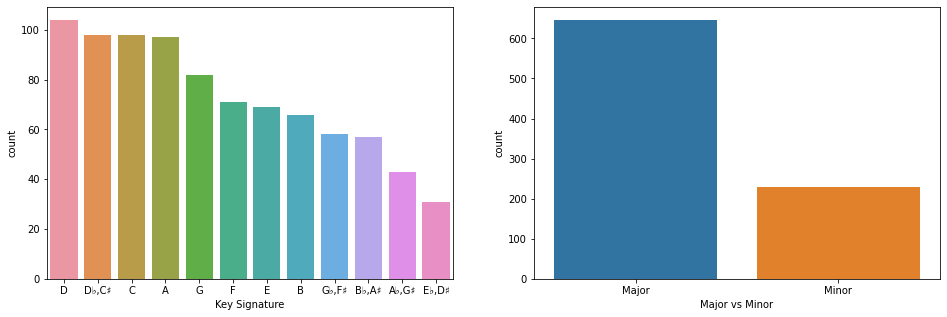

In [11]:
keys = {0:'C',1:'D♭,C♯',2:'D',3:'E♭,D♯',4:'E',5:'F',6:'G♭,F♯',7:'G',8:'A♭,G♯',9:'A',10:'B♭,A♯',11:'B'}
modes = {0:'Minor',1:'Major'}
df['Major vs Minor'] = df['mode'].map(modes)
df['Key Signature'] = df['key'].map(keys)
fig, axs = plt.subplots(figsize = (16,5), ncols=2)
sns.countplot(df['Key Signature'],order = df['Key Signature'].value_counts().index,ax=axs[0])
sns.countplot(df['Major vs Minor'],order = df['Major vs Minor'].value_counts().index,ax=axs[1])

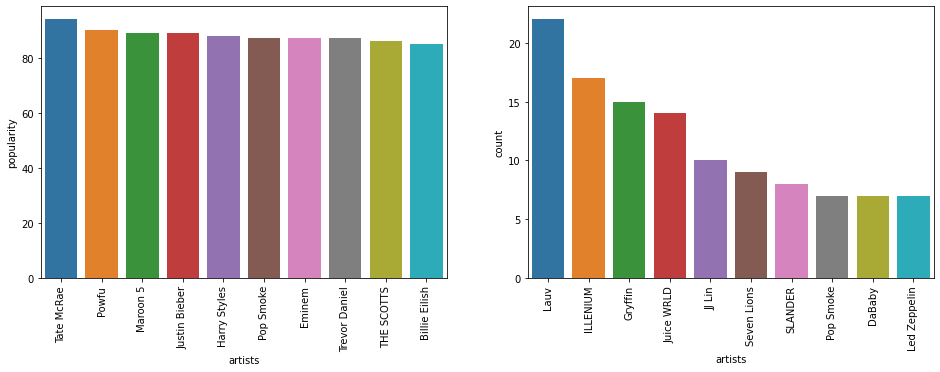

In [12]:
artists_popularity = df[['artists','popularity']].groupby('artists').mean().sort_values('popularity',ascending=False)[:10].reset_index()
artists_count = df[['artists','popularity']].groupby('artists').count().rename(columns={'popularity':'count'}).sort_values('count',ascending=False)[:10].reset_index()
fig, axs = plt.subplots(figsize = (16,5), ncols=2)
plot = sns.barplot(artists_popularity['artists'],artists_popularity['popularity'],ax=axs[0])
plot2 = sns.barplot(artists_count['artists'],artists_count['count'],ax=axs[1])
plot.set_xticklabels(plot.get_xticklabels(),rotation=90)
plot2.set_xticklabels(plot2.get_xticklabels(),rotation=90)
fig.show()

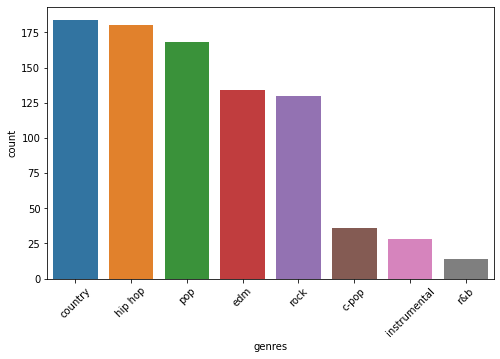

In [13]:
fig, axs = plt.subplots(figsize = (8,5))
plot = sns.countplot(df['genres'], order = df['genres'].value_counts().index)
plot.set_xticklabels(plot.get_xticklabels(),rotation=45)
fig.show()

<AxesSubplot:xlabel='valence', ylabel='Count'>

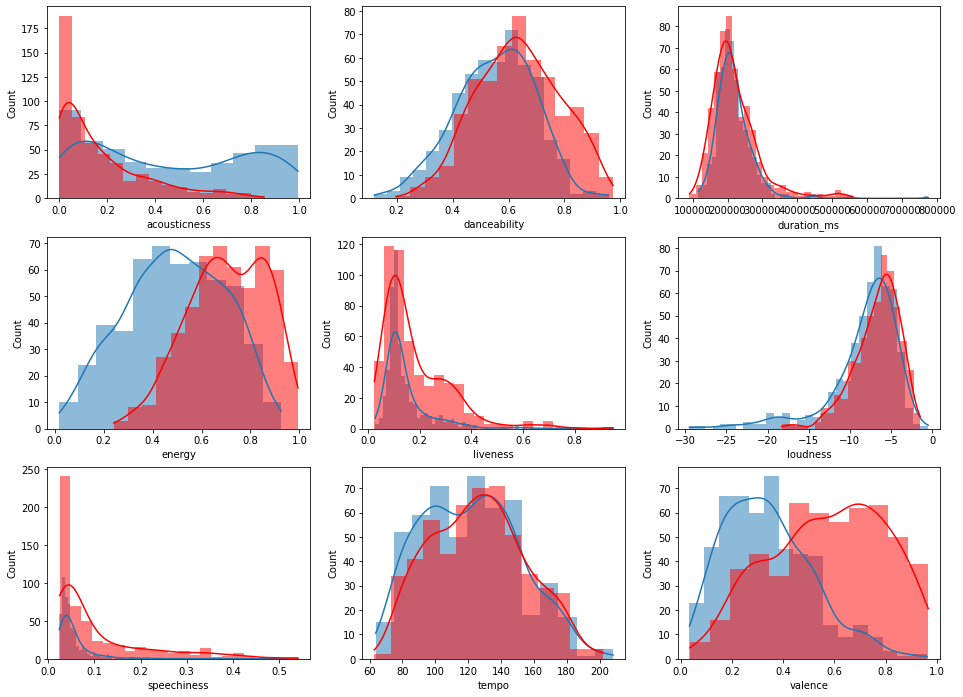

In [14]:
fig, axs = plt.subplots(figsize = (16,12), ncols=3, nrows = 3)
sns.histplot(data=likes,x='acousticness',kde=True,linewidth=0,ax=axs[0,0])
sns.histplot(data=dislikes,x='acousticness',color='red',kde=True,linewidth=0,ax=axs[0,0])
sns.histplot(data=likes,x='danceability',kde=True,linewidth=0,ax=axs[0,1])
sns.histplot(data=dislikes,x='danceability',color='red',kde=True,linewidth=0,ax=axs[0,1])
sns.histplot(data=likes,x='duration_ms',kde=True,linewidth=0,ax=axs[0,2])
sns.histplot(data=dislikes,x='duration_ms',color='red',kde=True,linewidth=0,ax=axs[0,2])
sns.histplot(data=likes,x='energy',kde=True,linewidth=0,ax=axs[1,0])
sns.histplot(data=dislikes,x='energy',color='red',kde=True,linewidth=0,ax=axs[1,0])
sns.histplot(data=likes,x='liveness',kde=True,linewidth=0,ax=axs[1,1])
sns.histplot(data=dislikes,x='liveness',color='red',kde=True,linewidth=0,ax=axs[1,1])
sns.histplot(data=likes,x='loudness',kde=True,linewidth=0,ax=axs[1,2])
sns.histplot(data=dislikes,x='loudness',color='red',kde=True,linewidth=0,ax=axs[1,2])
sns.histplot(data=likes,x='speechiness',kde=True,linewidth=0,ax=axs[2,0])
sns.histplot(data=dislikes,x='speechiness',color='red',kde=True,linewidth=0,ax=axs[2,0])
sns.histplot(data=likes,x='tempo',kde=True,linewidth=0,ax=axs[2,1])
sns.histplot(data=dislikes,x='tempo',color='red',kde=True,linewidth=0,ax=axs[2,1])
sns.histplot(data=likes,x='valence',kde=True,linewidth=0,ax=axs[2,2])
sns.histplot(data=dislikes,x='valence',color='red',kde=True,linewidth=0,ax=axs[2,2])


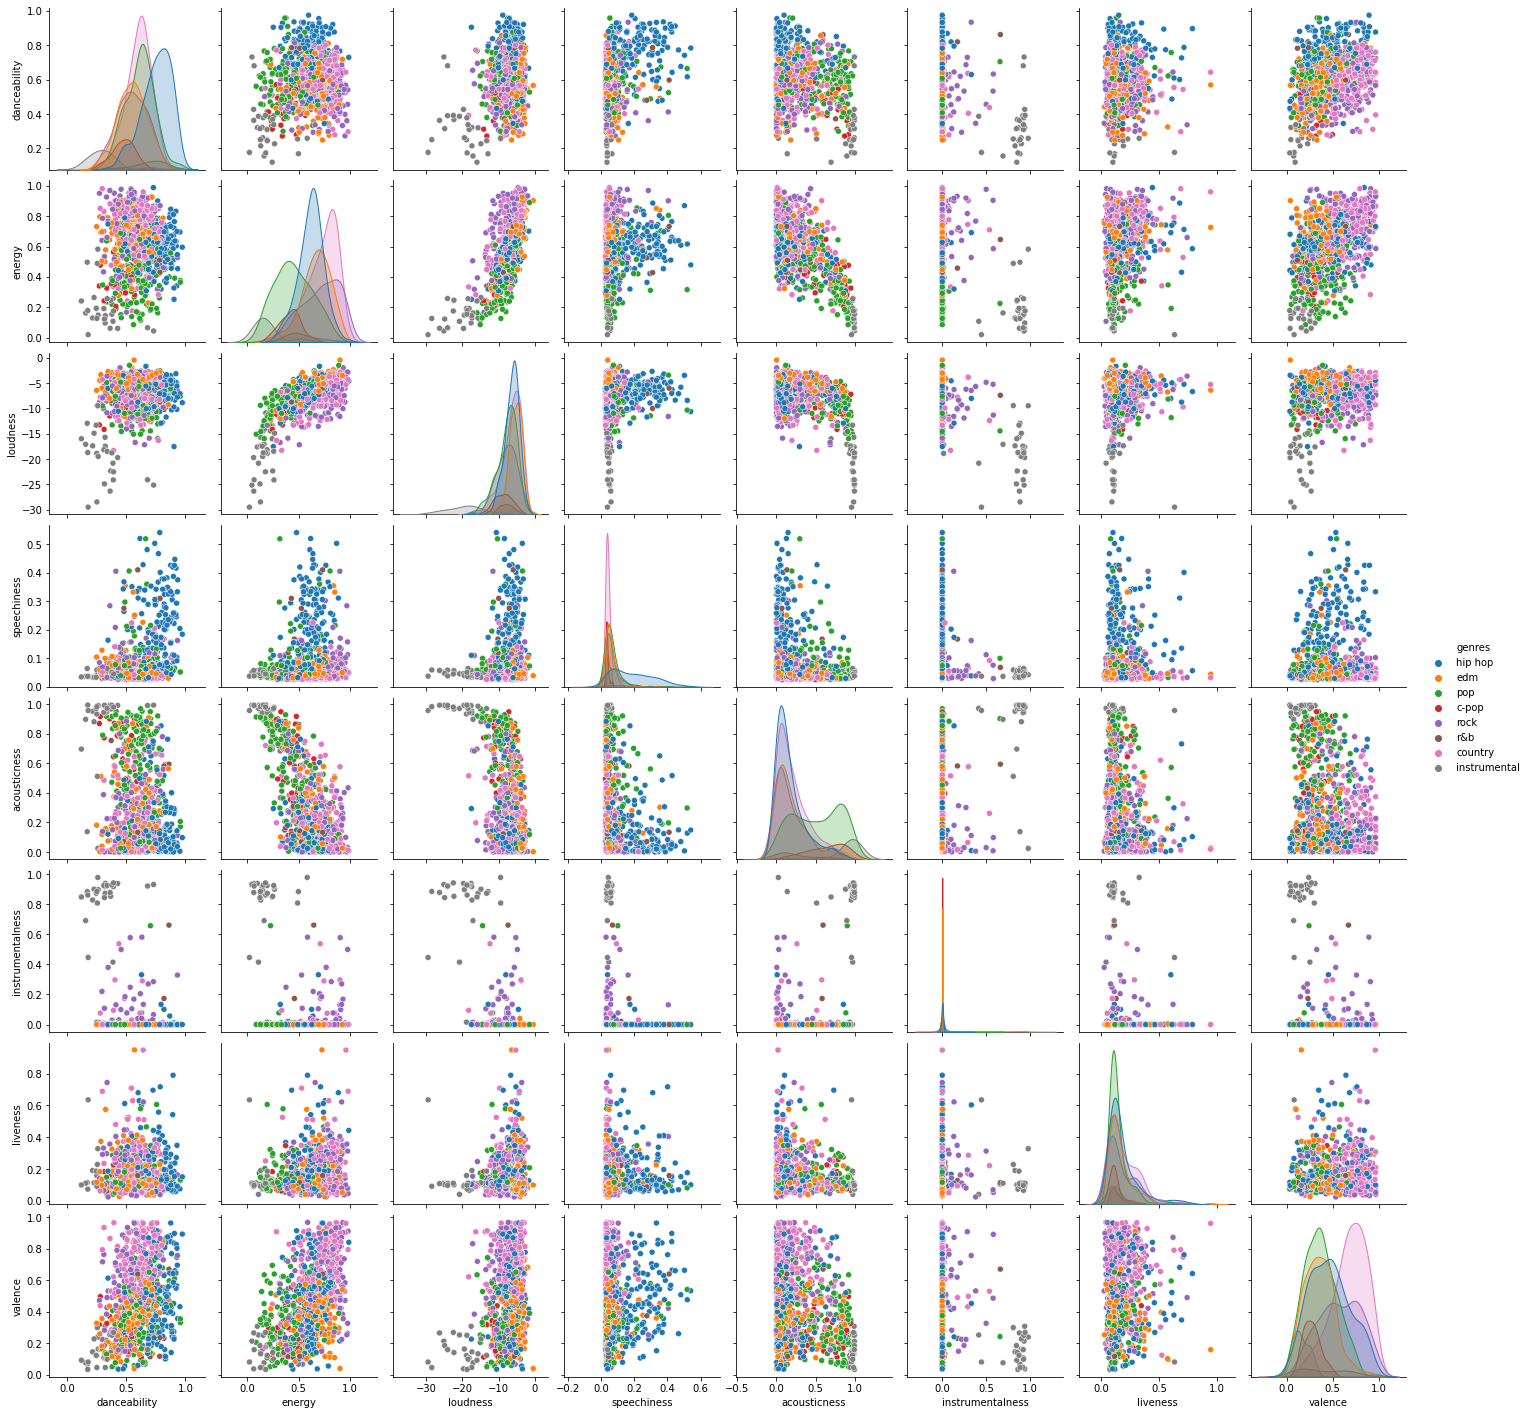

In [15]:
columns = ["genres","danceability","energy","loudness","speechiness","acousticness","instrumentalness","liveness","valence"]
sns.pairplot(df[columns],hue='genres')

## Popularity Prediction

Predicting the popularity of a song using audio features.

In [16]:
df['popular'] = [1 if i>=65 else 0 for i in df['popularity']]
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [17]:
columns = ["danceability","energy","loudness","speechiness","acousticness","instrumentalness","liveness","valence"]
x_train = train[columns]
y_train = train['popular']
x_test = test[columns]
y_test = test['popular']

In [18]:
model = LogisticRegression()
model.fit(x_train, y_train) 
print('Logistic Regression')
print('Training: ', model.score(x_train, y_train))
print('Test: ', model.score(x_test, y_test))
scores = cross_val_score(model, x_train, y_train, cv=5)
print('Cross-Validation Scores: ', scores)
print('Mean of Cross-Validation Scores: ', np.mean(scores))

Logistic Regression
Training:  0.6194563662374821
Test:  0.6
Cross-Validation Scores:  [0.66428571 0.58571429 0.62857143 0.64285714 0.58992806]
Mean of Cross-Validation Scores:  0.6222713257965056


In [19]:
parameters = [
    {'penalty': ['l1','l2'],
     'C': np.logspace(-4, 4, 15),
     'solver': ['newton-cg', 'lbfgs', 'liblinear']}
]

gs = GridSearchCV(model, parameters, cv=5, verbose = True, n_jobs=-1)
best_gs = gs.fit(x_train, y_train)
print('Test score with hyperparameter tuning: ', best_gs.score(x_test, y_test))

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.8s


Test score with hyperparameter tuning:  0.64


[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    3.2s finished


In [20]:
model = RandomForestClassifier()
model.fit(x_train, y_train)
print('Random Forests')
print('Training: ', model.score(x_train, y_train))
print('Test: ', model.score(x_test, y_test))

Random Forests
Training:  1.0
Test:  0.6228571428571429


In [21]:
parameters = [
    {'n_estimators': [10,100,1000],
     'max_features': ['sqrt','log2']}
]

gs = GridSearchCV(model, parameters, cv=5, verbose = True, n_jobs=-1)
best_gs = gs.fit(x_train, y_train)
print('Test score with hyperparameter tuning: ', best_gs.score(x_test, y_test))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.3s finished


Test score with hyperparameter tuning:  0.6514285714285715


<AxesSubplot:title={'center':'Feature Importances'}>

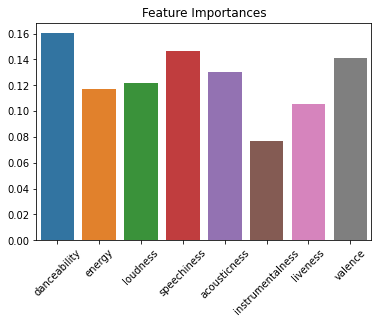

In [22]:
plot = sns.barplot(x_train.columns,model.feature_importances_)
plot.set_xticklabels(plot.get_xticklabels(),rotation=45)
plot.set_title('Feature Importances')
plot

Text(0.5, 1.0, 'With Hyperparameter Tuning')

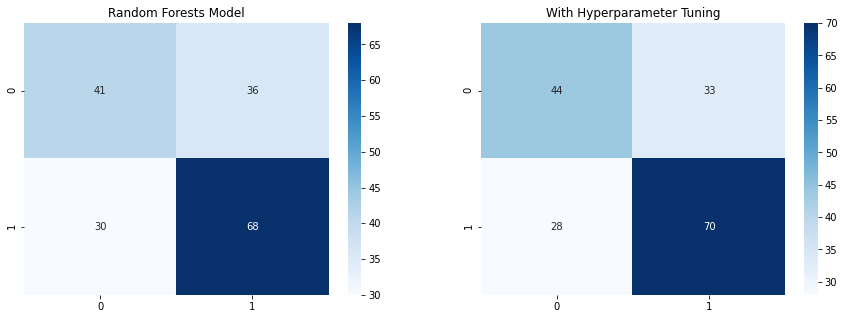

In [23]:
fig, axs = plt.subplots(figsize = (15,5), ncols=2)
prediction = model.predict(x_test)
conf_matrix = confusion_matrix(y_test.tolist(), prediction.tolist())
sns.heatmap(conf_matrix, cmap='Blues', annot=True, ax=axs[0])
axs[0].set_title('Random Forests Model')
prediction = best_gs.predict(x_test)
conf_matrix = confusion_matrix(y_test.tolist(), prediction.tolist())
sns.heatmap(conf_matrix, cmap='Blues', annot=True, ax=axs[1])
axs[1].set_title('With Hyperparameter Tuning')

## Genre Classification

In [24]:
train, test = train_test_split(df[df['like']==1], test_size=0.2, random_state=42)
columns = ["danceability","energy","loudness","speechiness","acousticness","instrumentalness","liveness","valence"]
x_train = train[columns]
y_train = train['genres']
x_test = test[columns]
y_test = test['genres']

In [25]:
model = LogisticRegression()
model.fit(x_train, y_train) 
print('Logistic Regression')
print('Training: ', model.score(x_train, y_train))
print('Test: ', model.score(x_test, y_test))
scores = cross_val_score(model, x_train, y_train, cv=5)
print('Cross-Validation Scores: ', scores)
print('Mean of Cross-Validation Scores: ', np.mean(scores))

Logistic Regression
Training:  0.631578947368421
Test:  0.6419753086419753
Cross-Validation Scores:  [0.64615385 0.66153846 0.56923077 0.5625     0.640625  ]
Mean of Cross-Validation Scores:  0.6160096153846154


In [26]:
parameters = [
    {'penalty': ['l1','l2'],
     'C': [100, 10, 1.0, 0.1, 0.01],
     'solver': ['newton-cg', 'lbfgs', 'liblinear']}
]

gs = GridSearchCV(model, parameters, cv=5, verbose = True, n_jobs=-1)
best_gs = gs.fit(x_train, y_train)
print('Test score with hyperparameter tuning: ', best_gs.score(x_test, y_test))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:    1.1s


Test score with hyperparameter tuning:  0.6790123456790124


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.3s finished


In [37]:
model = RandomForestClassifier()
model.fit(x_train, y_train)
print('Random Forests')
print('Training: ', model.score(x_train, y_train))
print('Test: ', model.score(x_test, y_test))

Random Forests
Training:  1.0
Test:  0.6419753086419753


In [40]:
parameters = [ 
    {'n_estimators': np.arange(100,1000,100),
    'max_features': ['auto', 'sqrt', 'log2']}
]

gs = GridSearchCV(model, parameters, cv=5, verbose = True, n_jobs=-1)
best_gs = gs.fit(x_train, y_train)
print('Test score with hyperparameter tuning: ', best_gs.score(x_test, y_test))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   42.0s finished


Test score with hyperparameter tuning:  0.6666666666666666


<AxesSubplot:title={'center':'Feature Importances'}>

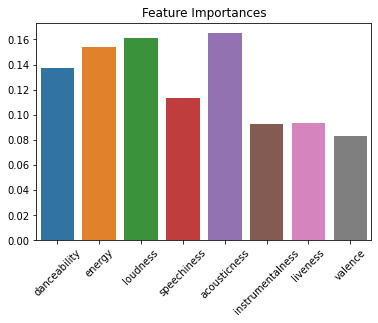

In [41]:
plot = sns.barplot(x_train.columns,model.feature_importances_)
plot.set_xticklabels(plot.get_xticklabels(),rotation=45)
plot.set_title('Feature Importances')
plot

Text(0.5, 1.0, 'With Hyperparameter Tuning')

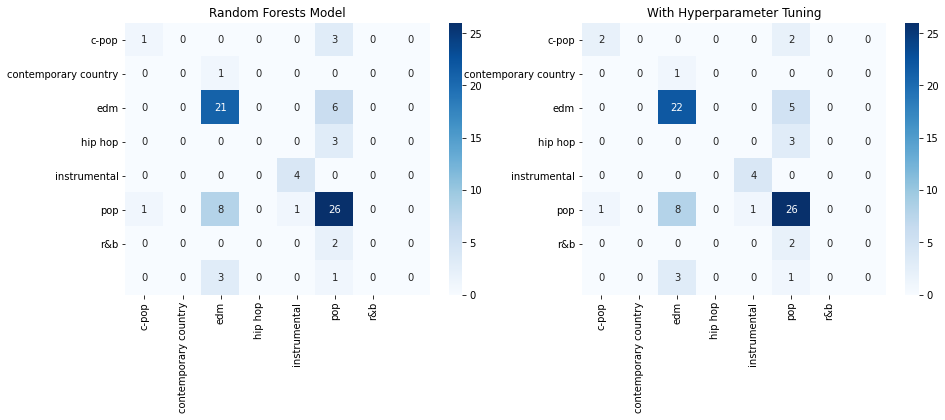

In [42]:
genres = ['c-pop','contemporary country','edm','hip hop','instrumental','pop','r&b']
fig, axs = plt.subplots(figsize = (15,5), ncols=2)
prediction = model.predict(x_test)
conf_matrix = confusion_matrix(y_test.tolist(), prediction.tolist())
sns.heatmap(conf_matrix, cmap='Blues', xticklabels=genres, yticklabels=genres, annot=True, ax=axs[0])
axs[0].set_title('Random Forests Model')
prediction = best_gs.predict(x_test)
conf_matrix = confusion_matrix(y_test.tolist(), prediction.tolist())
sns.heatmap(conf_matrix, cmap='Blues', xticklabels=genres, yticklabels=genres, annot=True, ax=axs[1])
axs[1].set_title('With Hyperparameter Tuning')

Several pop songs are being misclassified as edm songs and vice versa. This isn't unexpected since edm (especially mainstream edm) songs and pop songs have many similarities.

## Song Recommendations

Using songs that I like and dislike to recommend songs for myself.

In [71]:
train, val = train_test_split(df, test_size=0.2, random_state=42)
columns = ["danceability","energy","loudness","speechiness","acousticness","instrumentalness","liveness","valence"]
x_train = train[columns]
y_train = train['like']
x_val = val[columns]
y_val = val['like']

In [72]:
model = LogisticRegression()
model.fit(x_train, y_train) 
print('Logistic Regression')
print('Training: ', model.score(x_train, y_train))
print('Test: ', model.score(x_val, y_val))
scores = cross_val_score(model, x_train, y_train, cv=5)
print('Cross-Validation Scores: ', scores)
print('Mean of Cross-Validation Scores: ', np.mean(scores))

Logistic Regression
Training:  0.7854077253218884
Test:  0.8
Cross-Validation Scores:  [0.77857143 0.77857143 0.78571429 0.75       0.79136691]
Mean of Cross-Validation Scores:  0.7768448098663926


Text(0.5, 1.0, 'Model ROC Curve')

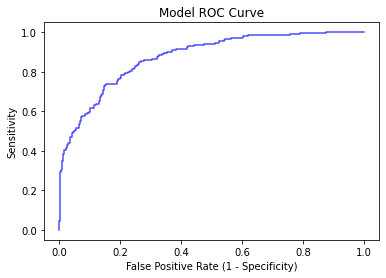

In [73]:
model_probabilities = model.predict_proba(x_train)[:, 1]
fpr, sv, thresholds = roc_curve(y_train, model_probabilities, pos_label=1)

plt.step(fpr, sv, color='b', alpha=0.7,
         where='post')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('Sensitivity')
plt.title('Model ROC Curve')

In [74]:
parameters = [
    {'penalty': ['l1','l2'],
     'C': [100, 10, 1.0, 0.1, 0.01],
     'solver': ['newton-cg', 'lbfgs', 'liblinear']}
]

gs = GridSearchCV(model, parameters, cv=5, verbose = True, n_jobs=-1)
best_gs = gs.fit(x_train, y_train)
print('Test score with hyperparameter tuning: ', best_gs.score(x_val, y_val))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Test score with hyperparameter tuning:  0.8228571428571428


[Parallel(n_jobs=-1)]: Done 123 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished


In [75]:
model = RandomForestClassifier()
model.fit(x_train, y_train)
print('Random Forests')
print('Training: ', model.score(x_train, y_train))
print('Test: ', model.score(x_val, y_val))

Random Forests
Training:  0.9985693848354793
Test:  0.8571428571428571


<AxesSubplot:title={'center':'Feature Importances'}>

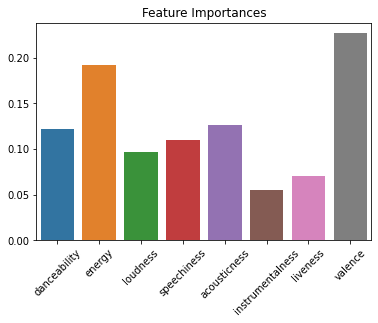

In [76]:
plot = sns.barplot(x_train.columns,model.feature_importances_)
plot.set_xticklabels(plot.get_xticklabels(),rotation=45)
plot.set_title('Feature Importances')
plot

In [78]:
parameters = [
    {'n_estimators': np.arange(10,200,10),
     'max_features': ['sqrt','log2']}
]

gs = GridSearchCV(model, parameters, cv=5, verbose = True, n_jobs=-1)
best_gs = gs.fit(x_train, y_train)
print('Test score with hyperparameter tuning: ', best_gs.score(x_val, y_val))

Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 183 out of 190 | elapsed:   12.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:   13.5s finished


Test score with hyperparameter tuning:  0.8742857142857143


Text(0.5, 1.0, 'With Hyperparameter Tuning')

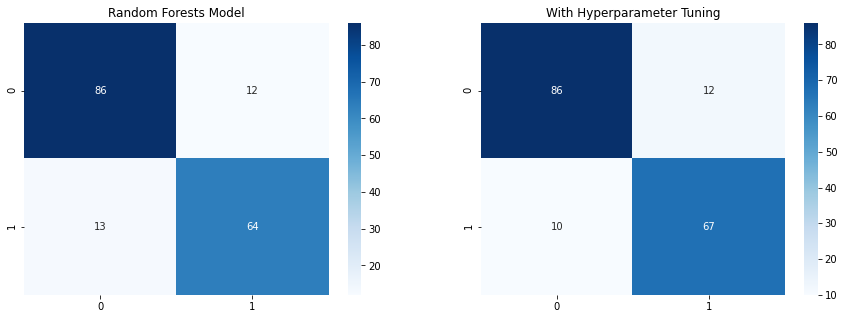

In [79]:
fig, axs = plt.subplots(figsize = (15,5), ncols=2)
prediction = model.predict(x_val)
conf_matrix = confusion_matrix(y_val.tolist(), prediction.tolist())
sns.heatmap(conf_matrix, cmap='Blues', annot=True, ax=axs[0])
axs[0].set_title('Random Forests Model')
prediction = best_gs.predict(x_val)
conf_matrix = confusion_matrix(y_val.tolist(), prediction.tolist())
sns.heatmap(conf_matrix, cmap='Blues', annot=True, ax=axs[1])
axs[1].set_title('With Hyperparameter Tuning')

In [80]:
#use model on all songs from 2020 to predict songs I would like
test = pd.read_csv('data.csv')
test = test[test['year']==2020].reset_index(drop=True)

In [81]:
test['predictions'] = best_gs.predict(test[columns])
test[test['predictions']==1].reset_index(drop=True)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,predictions
0,0.1450,2020,0.40100,"['Bad Bunny', 'Jhay Cortez']",0.731,205090,0.57300,1,47EiUVwUp4C9fGccaPuUCS,0.000052,4,0.1130,-10.059,0,Dakiti,100,2020-10-30,0.0544,109.928,1
1,0.3720,2020,0.19600,"['Justin Bieber', 'Chance the Rapper']",0.673,212093,0.70400,0,5u1n1kITHCxxp8twBcZxWy,0.000000,6,0.0898,-8.056,1,Holy (feat. Chance The Rapper),95,2020-09-18,0.3600,86.919,1
2,0.3340,2020,0.00146,['The Weeknd'],0.514,200040,0.73000,0,0VjIjW4GlUZAMYd2vXMi3b,0.000095,1,0.0897,-5.934,1,Blinding Lights,96,2020-03-20,0.0598,171.005,1
3,0.2700,2020,0.58400,['Conan Gray'],0.357,198040,0.42500,0,4xqrdfXkTW4T0RauPLv3WA,0.000000,5,0.3220,-7.301,1,Heather,93,2020-03-20,0.0333,102.078,1
4,0.0927,2020,0.86400,"['Justin Bieber', 'benny blanco']",0.631,149297,0.23900,1,4y4spB9m0Q6026KfkAvy9Q,0.000000,11,0.1160,-7.071,0,Lonely (with benny blanco),95,2020-10-16,0.0398,79.859,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,0.2100,2020,0.96800,['Lana Del Rey'],0.234,186000,0.11400,0,25Mld9UGdMqXYDU2x8l3ld,0.003910,11,0.1030,-19.136,0,Summertime The Gershwin Version,57,2020-11-19,0.0366,189.986,1
586,0.1870,2020,0.57400,['Bazzi'],0.445,176250,0.33000,0,0PUkanqCGTb6qseXPKOw1F,0.000000,9,0.1020,-8.121,1,I Don't Think I'm Okay,69,2020-07-09,0.0429,128.025,1
587,0.2400,2020,0.81500,['Bryson Tiller'],0.467,179188,0.42900,0,6Iw6fQVKZi0fWtEQBrTFcP,0.000052,6,0.1770,-8.689,0,Timeless Interlude,65,2020-10-02,0.0964,148.530,1
588,0.1690,2020,0.99400,['Ólafur Arnalds'],0.281,190500,0.03330,0,13MOQ6oQqkrZEDkZOHukCw,0.959000,6,0.0995,-31.460,1,We Contain Multitudes (from home),70,2020-08-26,0.0348,90.250,1
